# Финальный проект по направлению Data Engineer. Junior 

Цель проекта - пазработка пайплайна и структур хранения данных для анализа данных о поездках такси Нью-Йорка с 01.01.2009 по настоящее время. Полное описание задания на проект - в файле <a href="Описание финальной работы курса «Data Engineer. Junior».pdf">Описание финальной работы курса «Data Engineer. Junior».pdf</a>

## Используемый стек

- Airflow - для оркестрации ETL
- Spark - для обработки больших массивов данных
- Clickhouse - для хранения данных

## Разработка схемы данных

### Staging-слой

В staging-слое используем только таблицу bronze_files для отслеживания, какие файлы были скачаны и какие из них обработаны для серебряного и золотого слоев.

Схема БД staging-слоя:

![Staging layer schema-2.png](<attachment:Staging layer schema-2.png>)
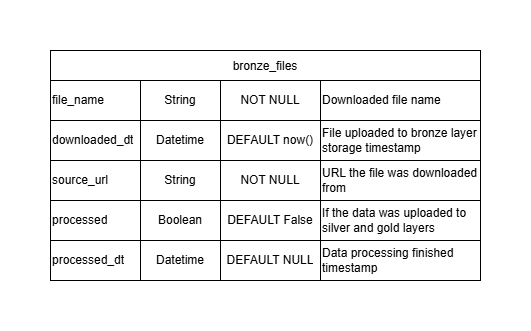

### Серебряный слой

Основной бизнес-сущностью для серебряного слоя является поездка. Данные о поездке фиксируются по ее завершении и более не изменяются. Поездка связана с небольшим числом справочников (зоны, тип оплаты и т.п.), записи в которых тоже не меняются, могут только добавляться или удаляться. Схема исходных файлов данных меняется очень мало. Таким образом, методология Data Vault 2.0 для серебряного слоя будет избыточна. Выбираем подход Инмона.

Основные данные о поездке хранятся в таблице trip_main_details. Для уменьшения ширины таблицы все денежные поля (кроме fare_amount), составляющие total_amount, выносим в отдельную таблицу trip_fin_details. Так как данные о совершившейся поездке не меняются со временем, поддержка версионности не нужна. Используем движок ReplacingMergeTree для удаления дубликатов в случае повторной загрузки из одного источника. Партиционируем по времени начала поездки ежемесячно. Для этого в таблицу trip_fin_details так же добавляем дату начала поездки.

Справочники:
- зона посадки/высадки;
- способ оплаты,
- поставщик информации;
- тариф;
- вид такси;
- вид поездки

представляют собой небольшие таблицы, данные в которых не меняются со временем - могут только очень редко добавляться новые записи. Для экономии ресурсов используем движок TinyLog. Проверку на уникальность записей производим при загрузке данных в эти таблицы.

В таблицу trip_main_details добавляем вычисляемое поле trip_duration - продолжительность поездки в минутах, округленная до большей минуты. Это поле так же используем для очистки данных.

![Silver layer schema.png](<attachment:Silver layer schema.png>)
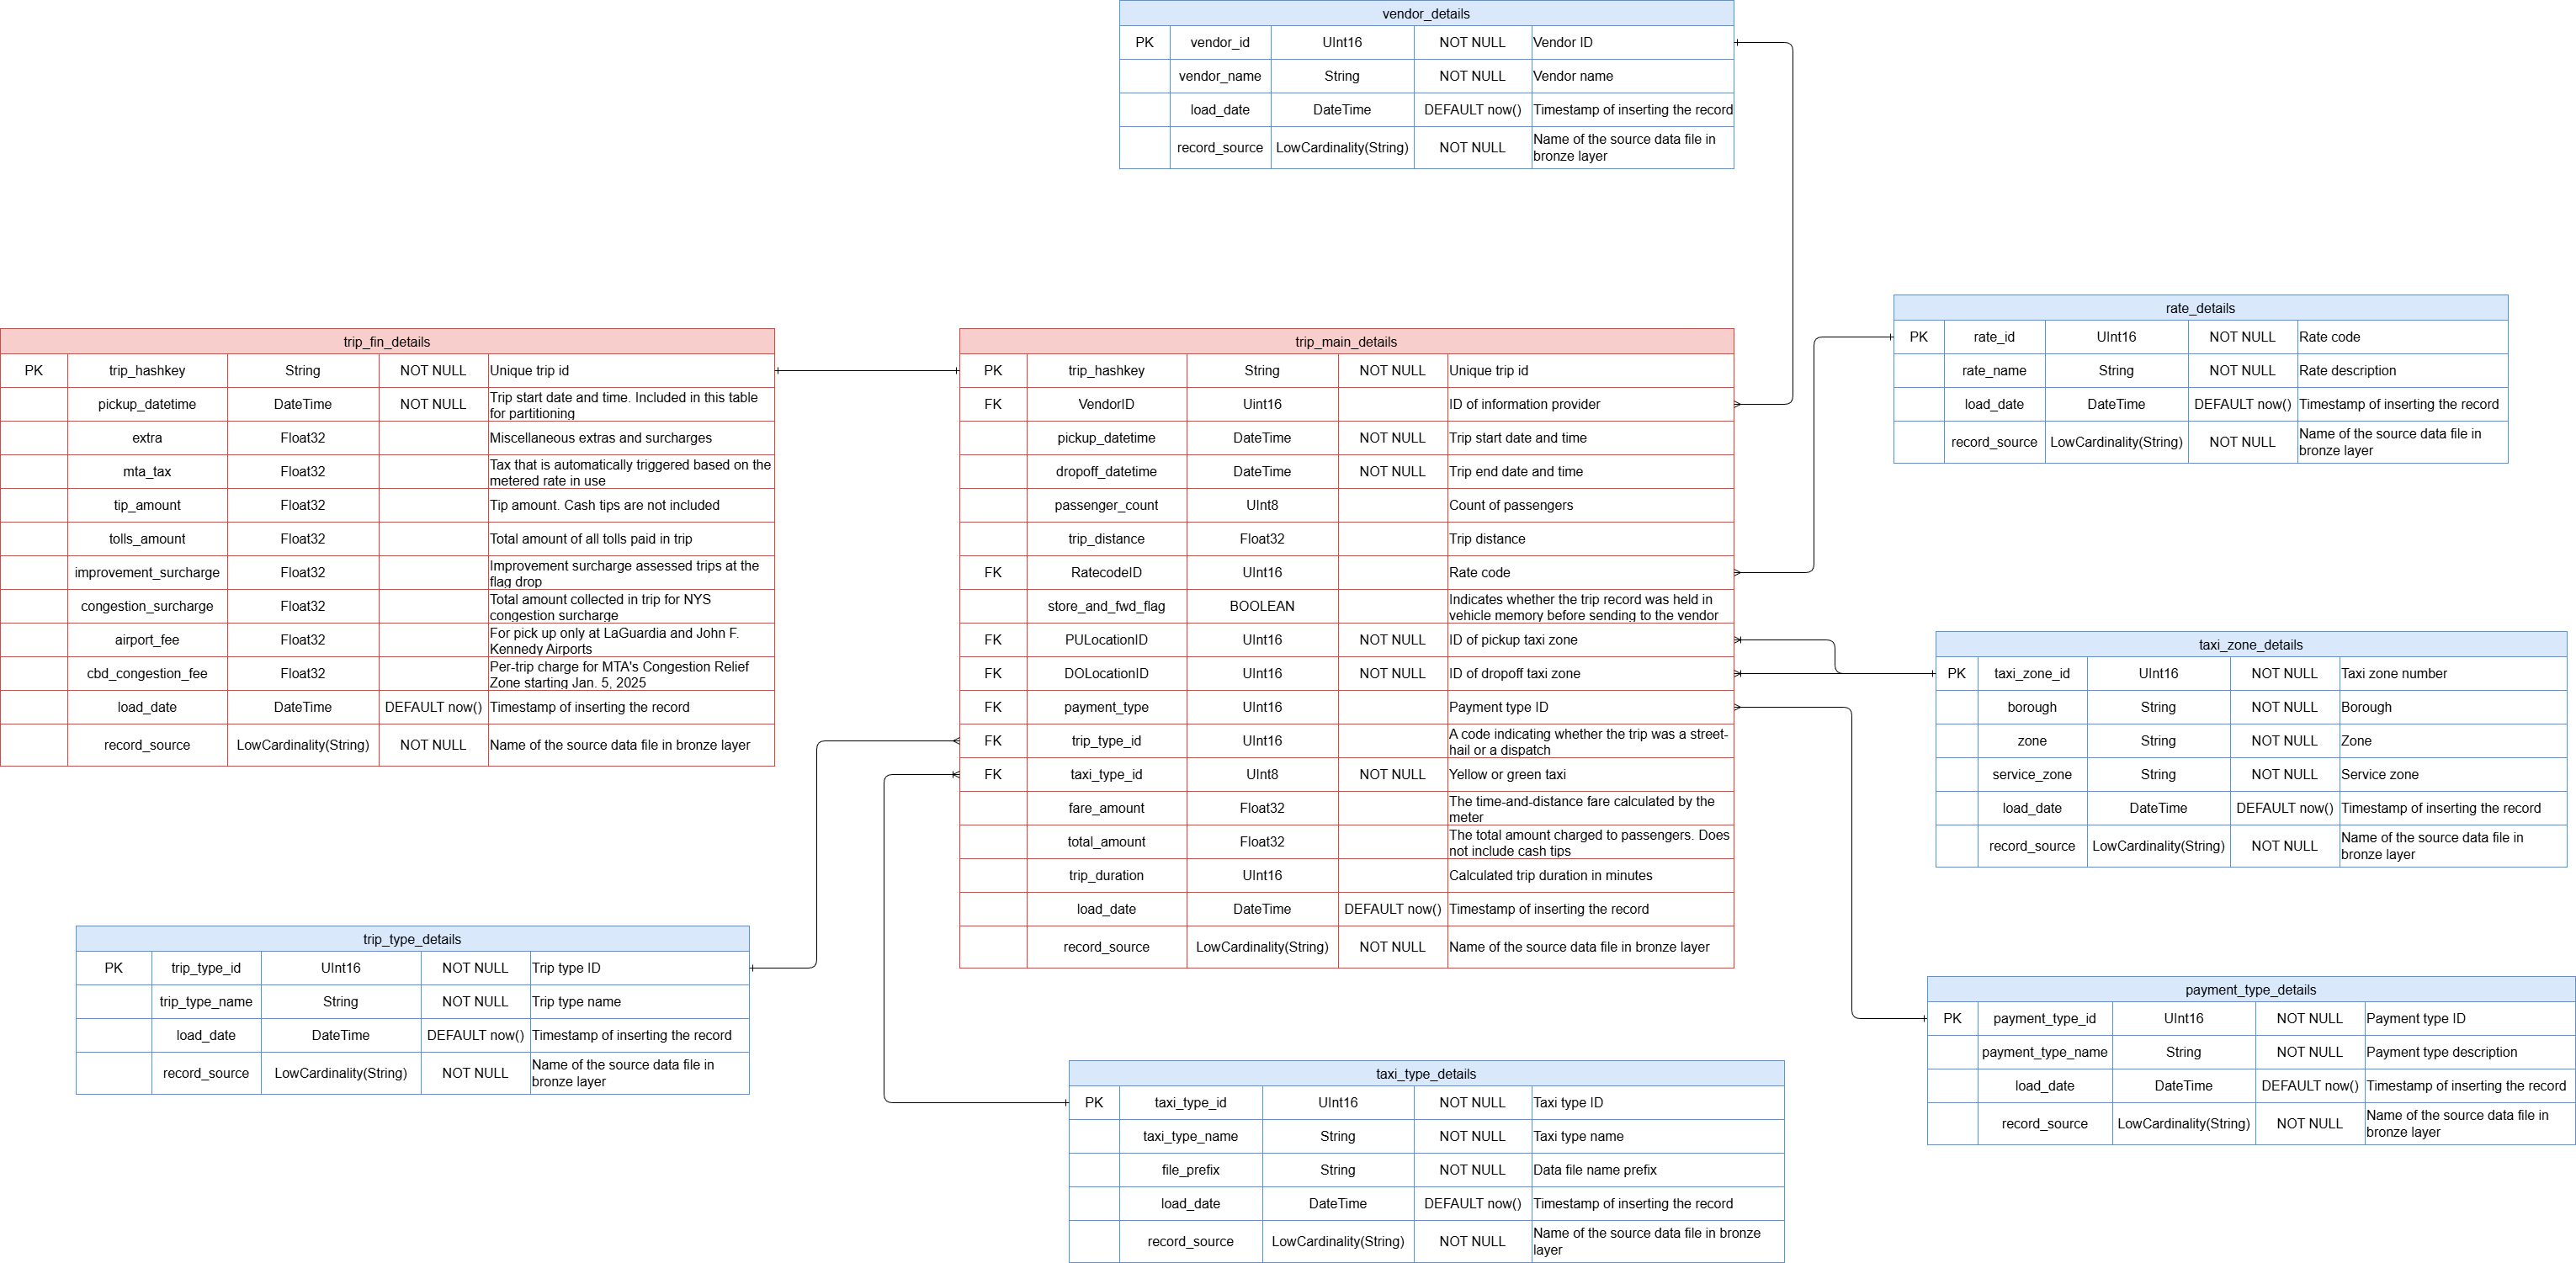

### Золотой слой

Золотой слой строим по методологии Кимбалла по схеме "звезда".

Единственная таблица фактов:
- поездка

Измерения:
- зона посадки/высадки
- время (деление на бакеты и производные поля: год, месяц, день, час, выходной или праздник)
- тип оплаты
- длительность поездки (деление на бакеты)
- протяженность поездки (деление на бакеты)

Таблицы измерений "зона посадки/высадки", "тип оплаты", "длительность" и "протяженность поездки" - небольшие и заполняются при создании слоя, меняются редко или никогда - используем движок TinyLog.
Таблица фактов о поездке и таблица измерения времени содержат основные данные и постоянно растут. Для исключения дублирования записей используем движок ReplacingMergeTree.

![Golden layer schema.png](<attachment:Golden layer schema.png>)
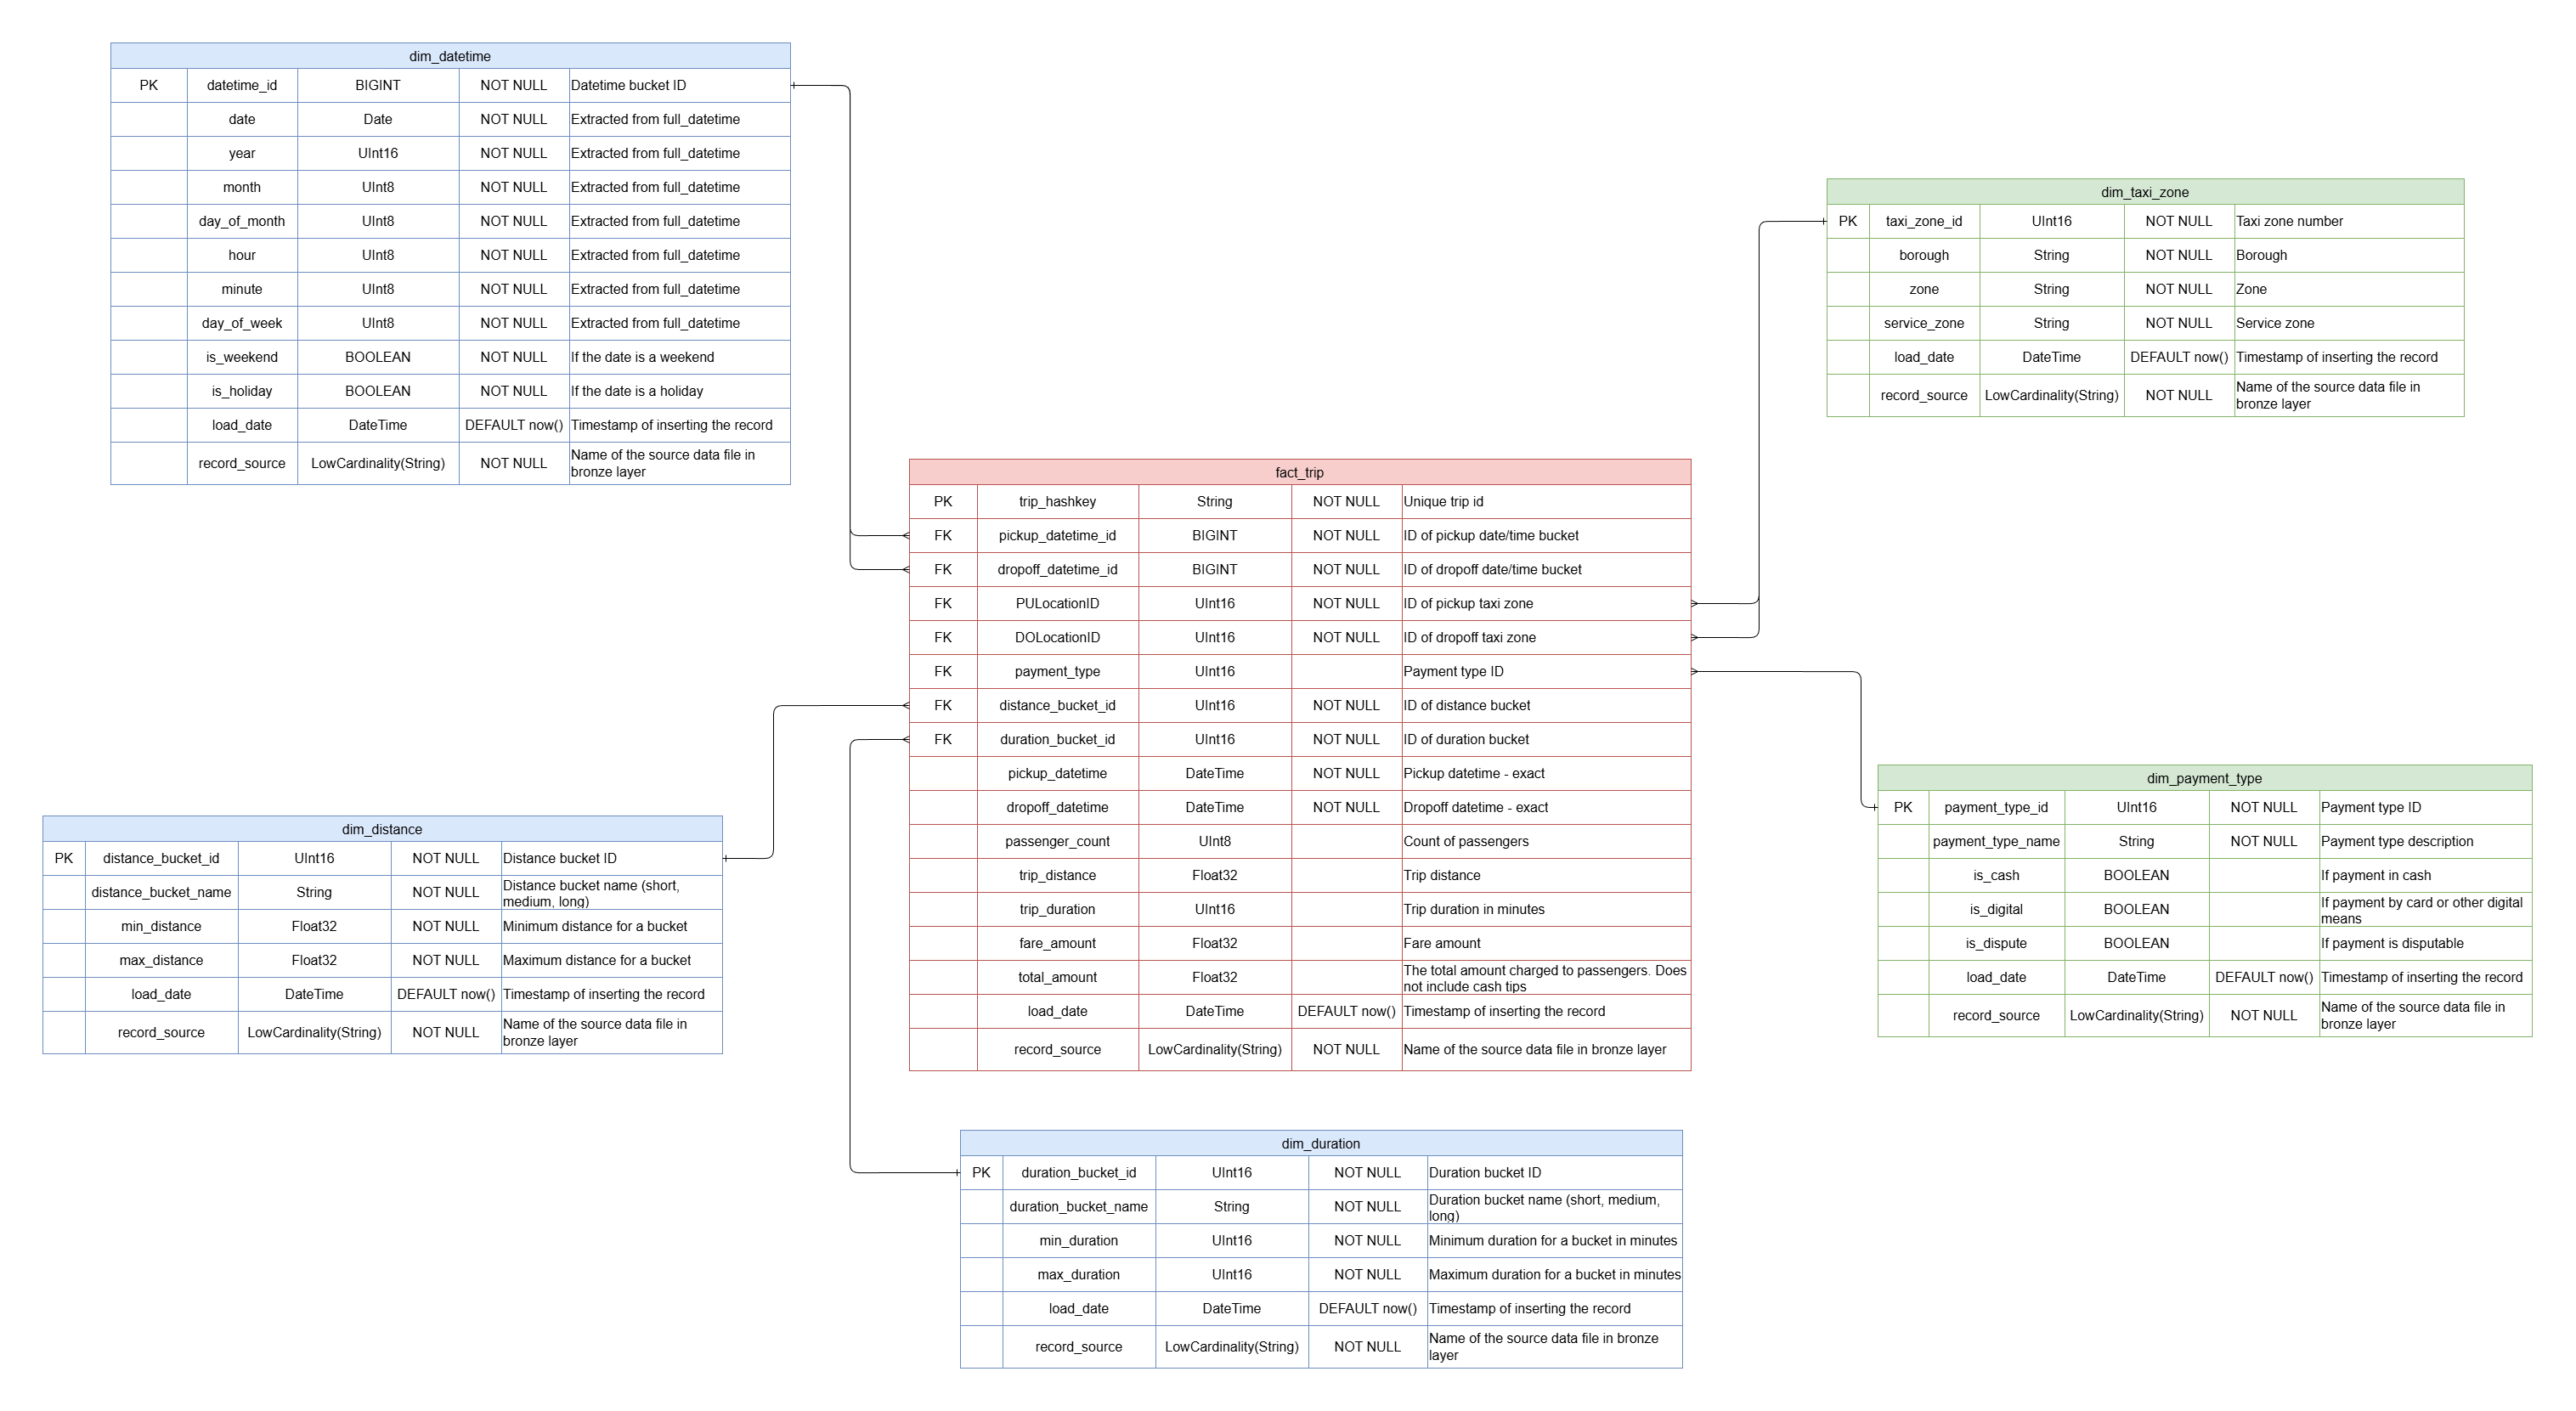

На основе выборки поездок строим распределение протяженности поездок и определяем границы категорий:

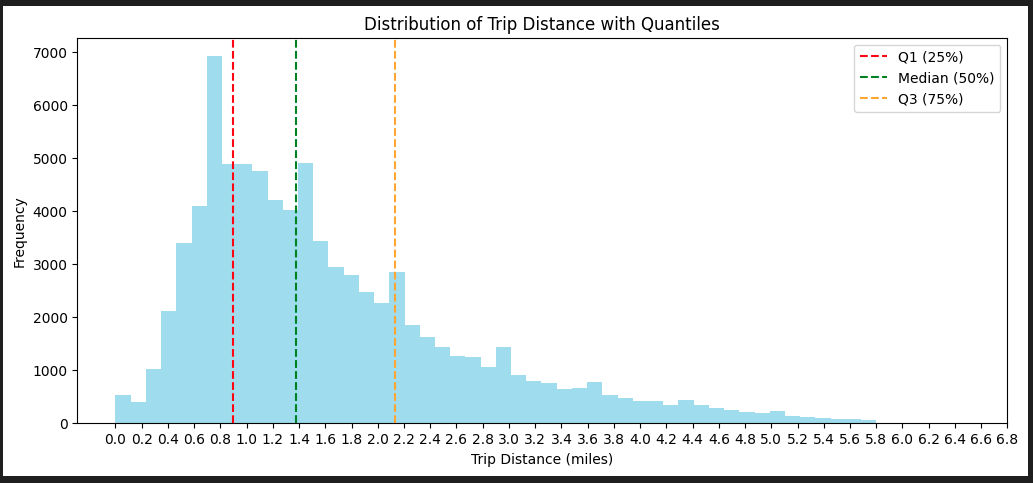

Выделяем категории:
- short: меньше 0.5 миль;
- normal: 0.5-1.5 мили;
- long: 1.5-3.0 мили;
- extra long: более 3 миль.

На основе той же выборки поездок строим распределение длительности поездок и определяем границы категорий:

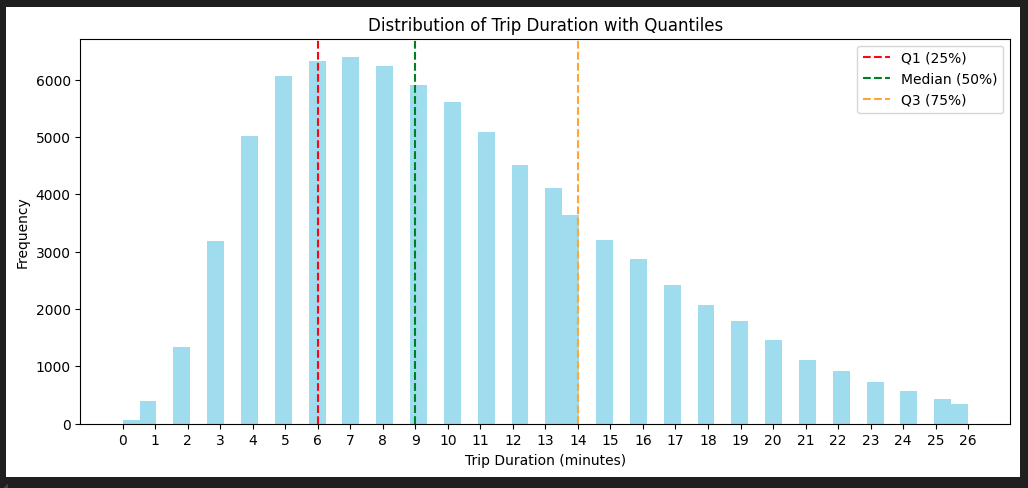

Выделяем категории:
- short: короче 4 минут;
- normal: 4-12 минут;
- long: 12-20 минут;
- extra-long: более 20 минут.

Для измерения dim_datetime выбираем округление до ближайших 5 минут - такое дробление не слишком избыточно, но позволит строить агрегаты по любому интервалу (например, 10-15-30 минут).

## Инициализация инфраструктуры

Инициализация проводится путем однократного запуска в Airflow DAG nyc_taxi_initalize. В рамках инициализации выполняются следующие действия:
- проверяется доступность необходимых хранилищ и бакетов. В случае отстуствия бакетов - пытаемся их создать.
- проверяется доступность сервера Clickhouse.
- проверяется существование необходимых БД в Clickhouse. В случае отсутствия - пытаемся их создать.
- создаются необходимые таблицы в каждой из БД. Так как таблицы создаются с использованием IF NOT EXISTS, предварительная проверка существования не проводится.
- скачивается файл со списком зон такси. Данные из файла загружаются в таблицу серебряного слоя taxi_zone_details и в таблицу золотого слоя dim_taxi_zone.


## Формирование бронзового слоя. Скачивание данных с источника

Исходные файлы данных скачиваются с сайта-источника и загружаются в хранилище бронзового слоя в неизменном виде. Скачивание производится регулярно с помощью Airflow DAG nyc_taxi_download_raw. Так как новые файлы появляются не чаще, чем раз в месяц и с двухмесячным опозданием, выбираем еженедельный запуск DAG. Информация о каждом скачанном файле сохраняется в таблице bronze_files базы данных staging-слоя. Задание на скачивание файла не связано с его последующим разбором, это независимые процессы.

## Обработка данных для staging, серебряного и золотого слоев

Файлы из бронзового слоя обрабатываются с помощью Airflow DAG nyc_taxi_etl. DAG запускается ежедневно и выбирает файлы из таблицы bronze_files, которые были скачаны в хранилище, но не обработаны ранее. Для каждого файла из списка:
- данные очищаются:
    - удаляются дубликаты по комбинации полей 'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'total_amount';
    - добавляются отсутствующие данные в поля taxi_type_id, trip_type_id;
    - для числовых полей (идентификаторы, расстояния, суммы и т.п.) удаляются отрицательные и слишком большие значения;
    - удаляются строки с выбросами в числовых полях (+/- 1.5 IRQ);
- данные загружаются в таблицы серебряного слоя;
- добавляются вычисляемые поля trip_duration, is_airport, is_holiday, is_weekend:
- добавляются производные поля (год, месяц, день, день недели и т.п.);
- каждая запись связывается с бакетами времени, расстояния и продолжительности;
- данные загружаются в таблицы золотого слоя;
- в таблице bronze_files файл помечается как обработанный, добавляется отметка времени окончания обработки.

## Ответы на аналитические вопросы

В рамках данного проекта для обработки данных используется кластер Spark в Yandex DataProc. Так как использование кластера стоит довольно дорого, создаем его по требованию и удаляем после обработки данных. Для того, чтобы меньше использовать кластер для ответа на аналитические вопросы создаем materialized view в Clickhouse - это позволит при необходимости обращаться к Clickhouse без использования Spark. Так как materialized view создаем только для агрегатов, потери места на них незначительны.


Вычисления для ответов аналитические запросы производятся в файле questions.ipynb

In [140]:
# Create Spark session
try:
    spark.stop()
except:
    pass

try:
    spark_conf = {
        'url': f"jdbc:clickhouse://{config['clickhouse']['host']}:{config['clickhouse']['port']}/{config['clickhouse']['golden_db']}",
        'driver': 'com.clickhouse.jdbc.ClickHouseDriver',
        'user': os.getenv('CLICKHOUSE_USER'),
        'password': os.getenv('CLICKHOUSE_PASS'),
        }

    spark = SparkSession.builder \
        .appName('DataAnlytics') \
        .master(config['spark']['master']) \
        .config('spark.driver.host', 'host.docker.internal') \
        .config('spark.driver.bindAddress', '0.0.0.0') \
        .config("spark.sql.session.timeZone", "UTC") \
        .getOrCreate()

    logging.info(f'Spark session created successfully')
except Exception as e:
    logging.error(f'Error connecting to Spark master: {e}')

### 1. Определить зоны с наибольшим количеством посадок и высадок

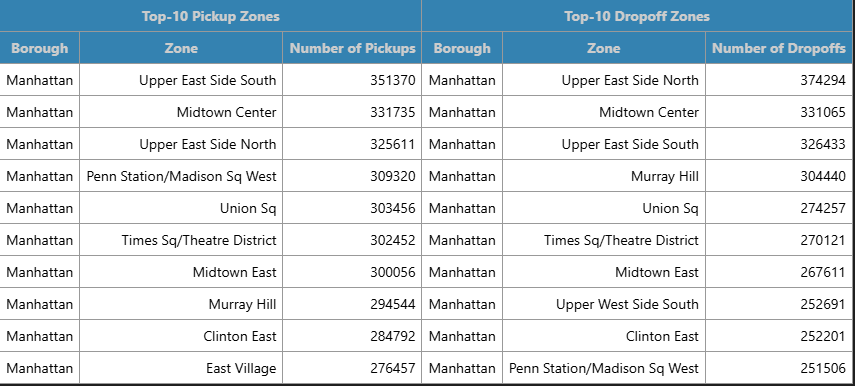

В топ-3, топ-5 и топ-10 лидирует Манхэттен. Данные - из materialized view mv_zones_counts.

### 2. Пиковые часы для поездок на такси

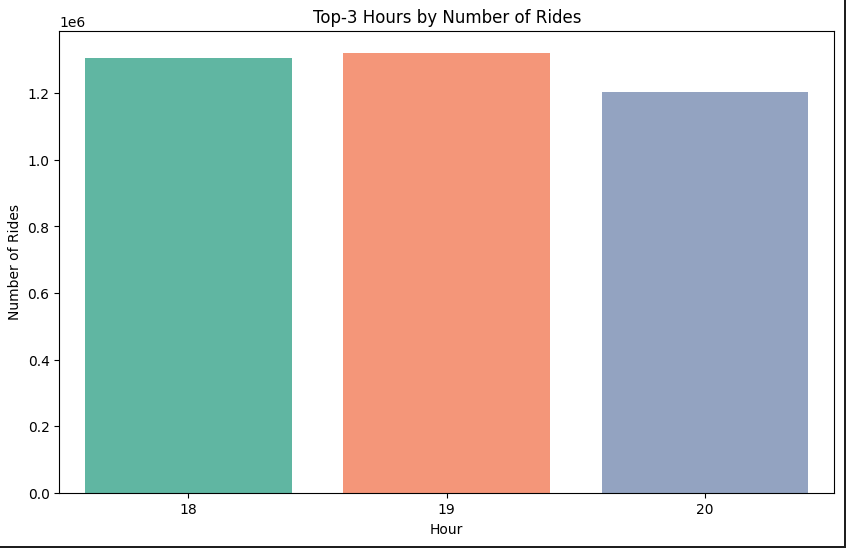

Максимум поездок приходится на вечерние часы, с 18 до 20 часов, что связано с возвращением людей с работы домой. Данные - из materialized view mv_rides_by_hour.

### 3. Распределение поездок и мотивы пассажиров

Полная гистограмма распределения числа поездок по часам (данные - из materialized view mv_rides_by_hour):

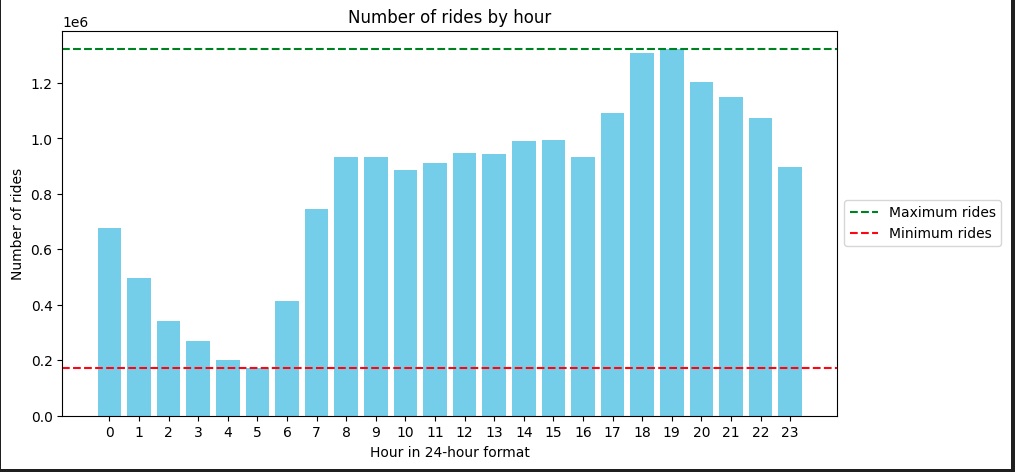

Минимум поездок наблюдается в 5 и 6 утра. С 7 и до 8 утра количество поездок нарастает, а после 8 выходит на плато. Максимум поездок приходится на 18 и 19 часов, после чего количество поездок начинает равномерно уменьшатся с каждым часом.

Для выявления паттерна поездок на работу исключаем выходные, праздники и поездки в аэропорты и из аэропортов. Используем materialized view mv_workdays_by_hour.

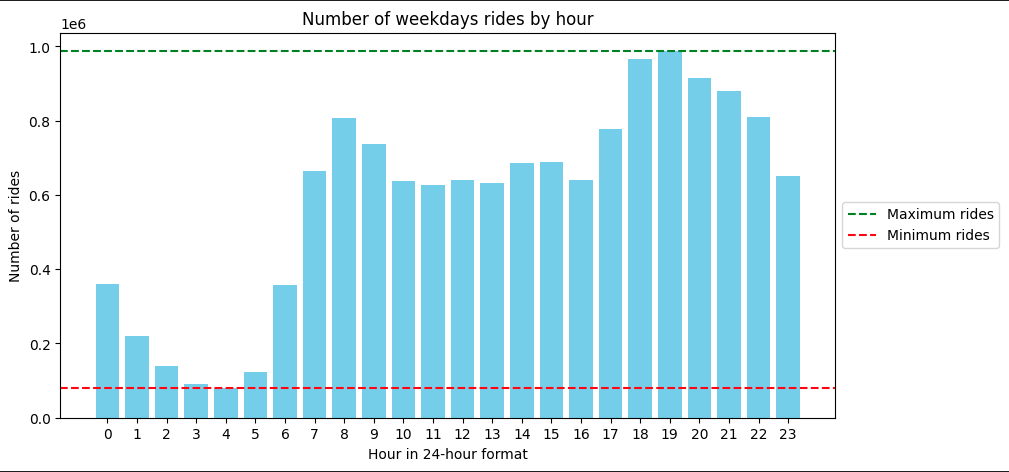

На этом графике более отчетливо выделяются утренние часы пик с 7 до 9 утра и вечерние с 18 до 20 - люди едут на работу и с работы.

Построим гистограмму распределения поездок по выходным (materialized view mv_weekends_by_hour):

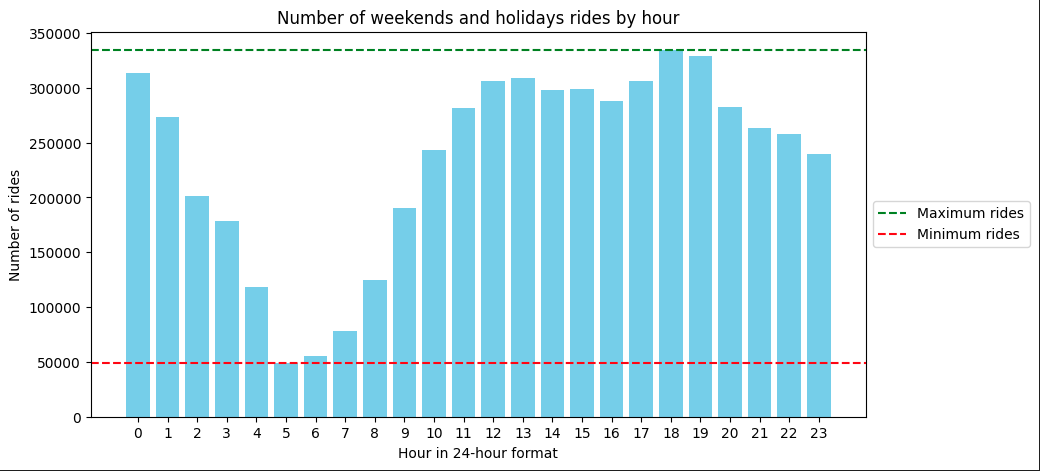

Из графика видно, что утренний минимум смещен на час позже, далее трафик постепенно растет со слабо выраженным пиком около полудня и до обычного максимума в вечерние часы пик 18 и 19, но также наблюдается всплеск поездок в районе полуночи: люди разъезжаются из баров.

### 4. Пиковые часы для коротких и длинных поездок

Используем 4 категории поездок: короткие, нормальные, длинные и сверхдлинные. Рассматриваем как в разрезе времени, так и в разрезе расстояния.

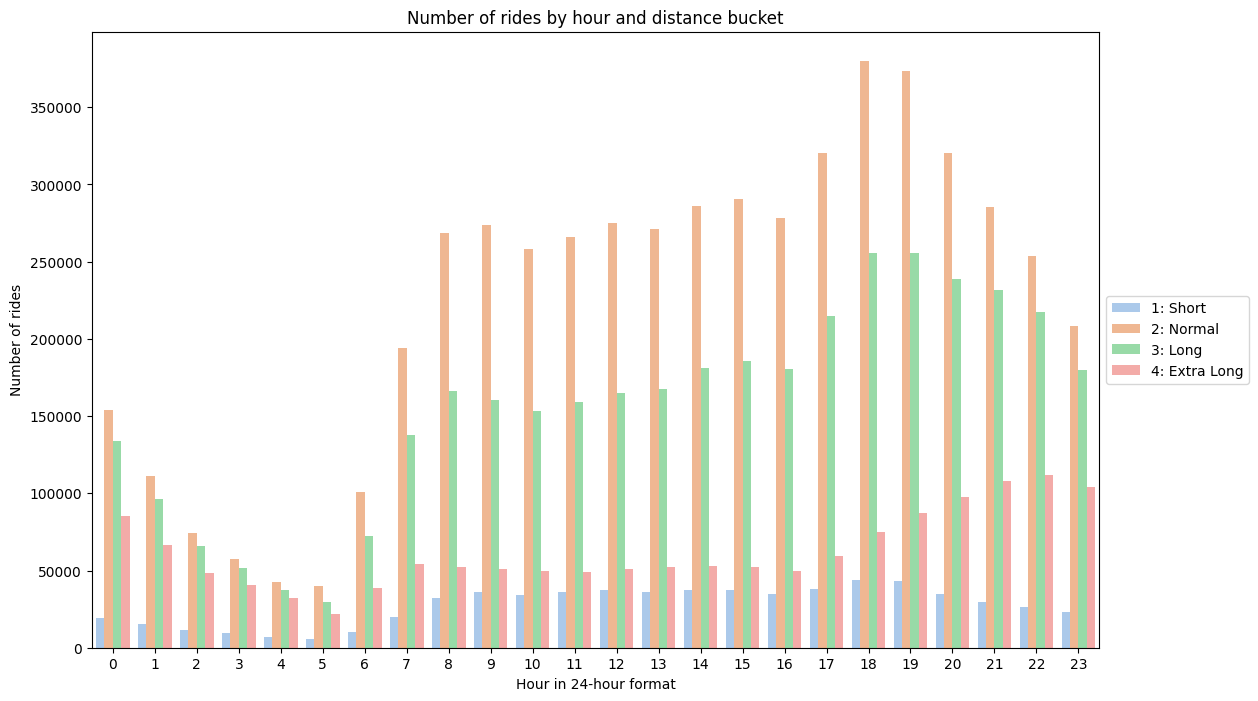

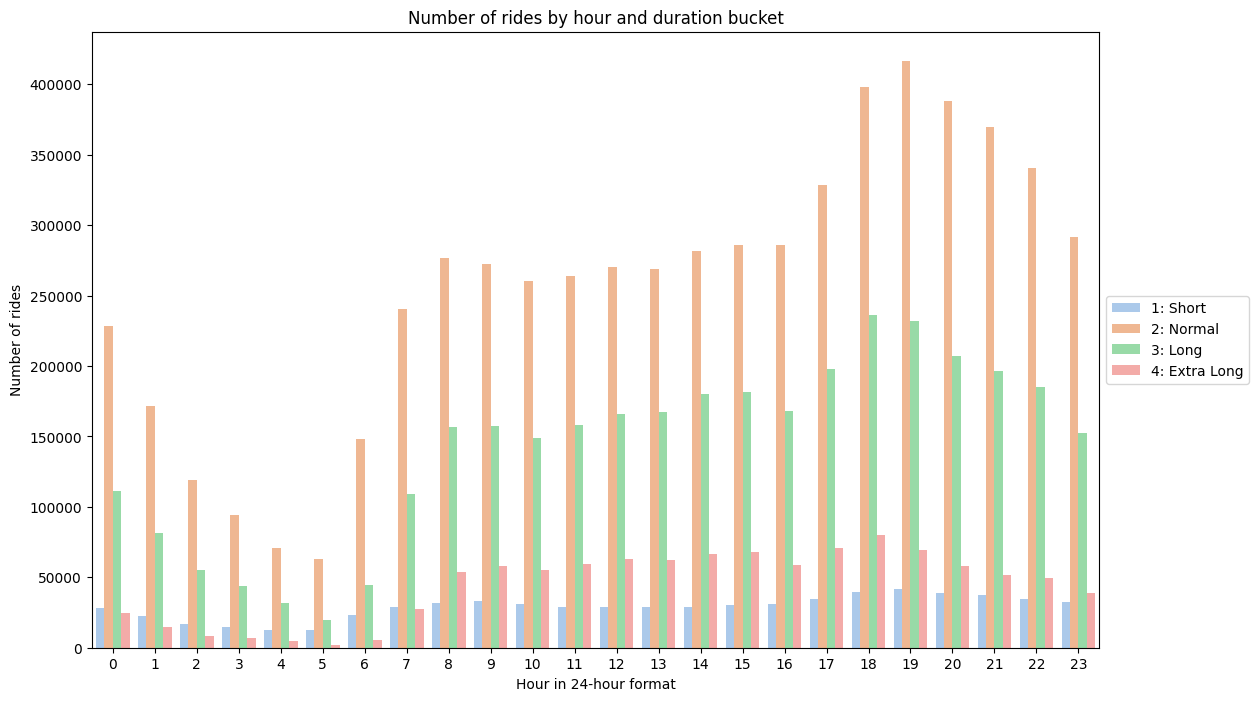

Из графиков видно, что количество поедок длиннее 3 миль продолжает расти после 18 до максимума около 22 часов, хотя количество поездок короче 3 миль начинает падать.

### 5. Топ-3 зон посадки и высадки для разных типов поездок

Рассматриваем следующие категории поездок:
1. Поездки в аэропорты и из них. Выделяем, так как они не подчиняются "обычному" распределению поездок, а зависят от расписания рейсов. Фильтруем на основе зоны посадки/высадки.
2. Поездки в утренние и вечерние часы пик по рабочим дням: большая часть таких поездок - это поездки на работу и обратно. Фильтруем по времени суток рабочего дня.
3. Поездки по выходным - шоппинг и развлечения. Фильтруем по флагам 'is_weekend', 'is_holiday'.
4. Поездки в пределах одной зоны. Выделяем, так как профиль пассажира может отличаться от среднего - размер зон небольшой, можно пройти и пешком.
5. Поездки между боро - составляют меньше 10%, интересно исследовать подробнее

Каждая поездка может относиться к нескольким категориям. Для этого создаем отдельный materialized view с категориями для каждой поездки. Выбор materialized view вместо отдельной таблицы измерений обусловлен тем, что все необходимые данные уже содержатся в других таблицах измерений, при этом представление можно будет при необходимости легко переопределить без изменений структуры БД и ETL-пайплайна.



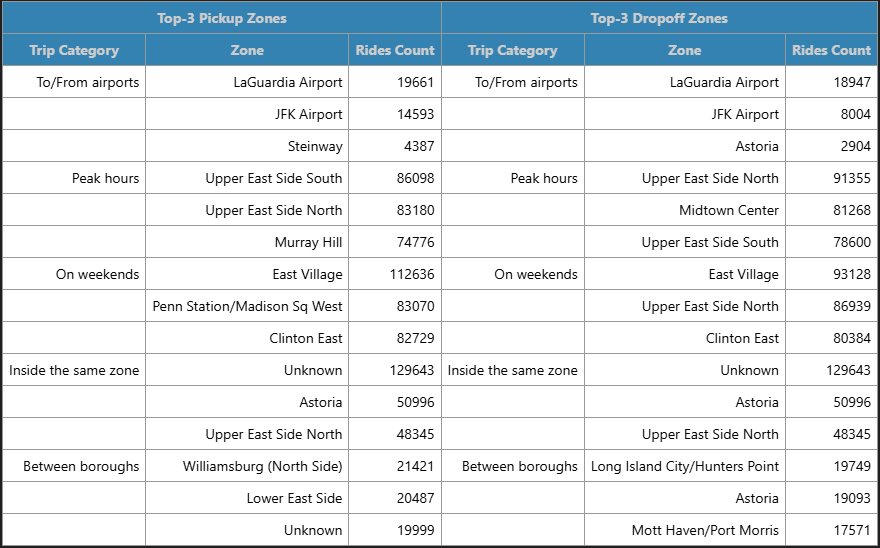

Топ зон начала поездки по категориям на графике:

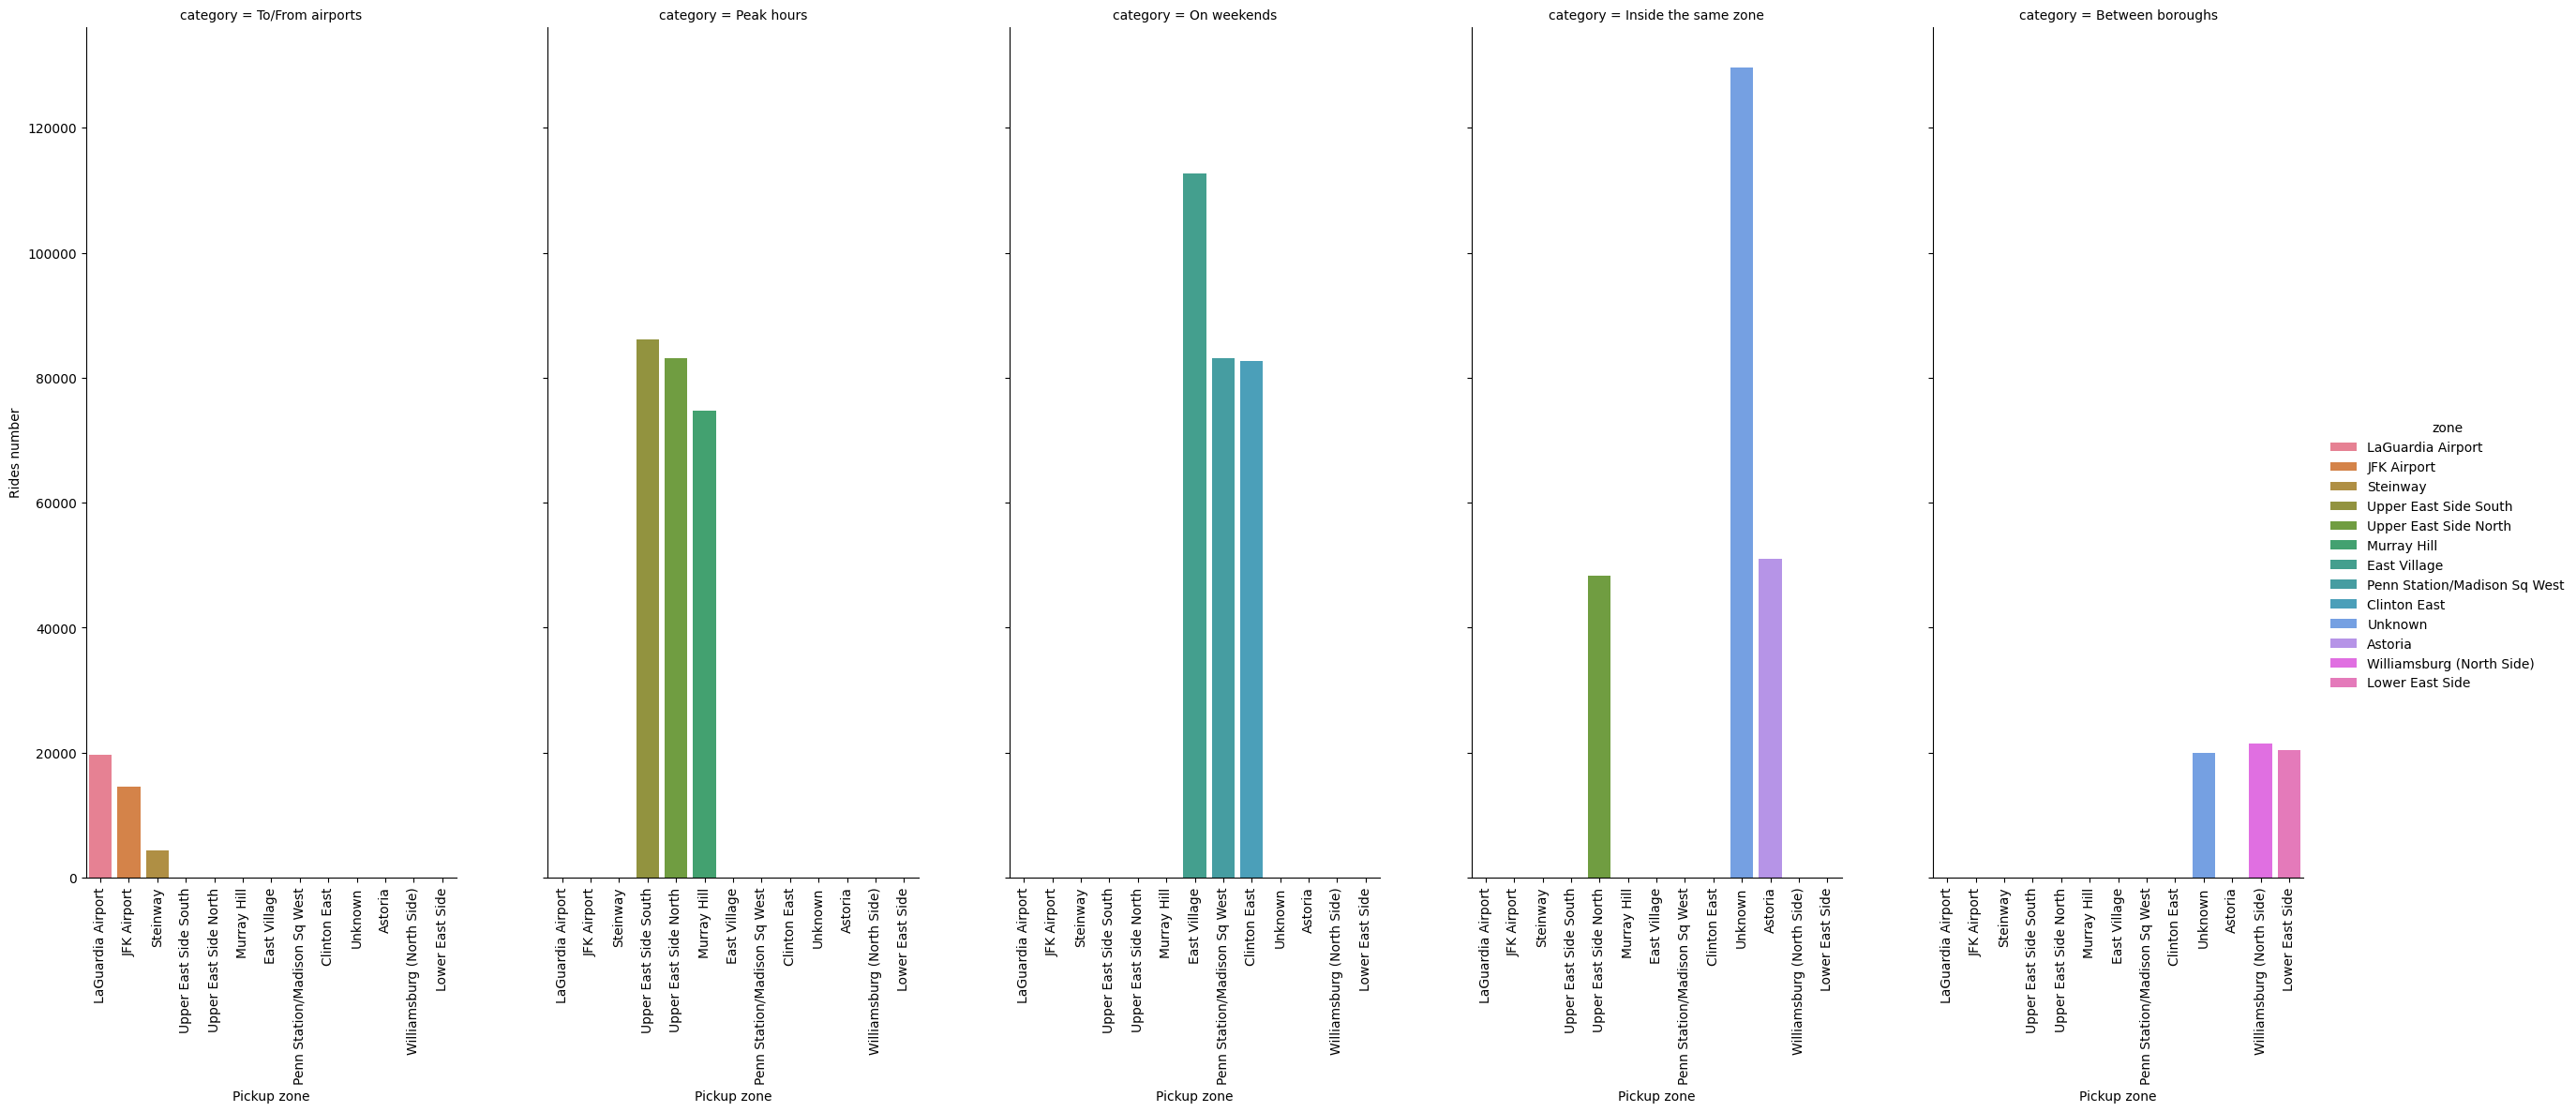

Топ зон завершения поездок по категориям на графике:

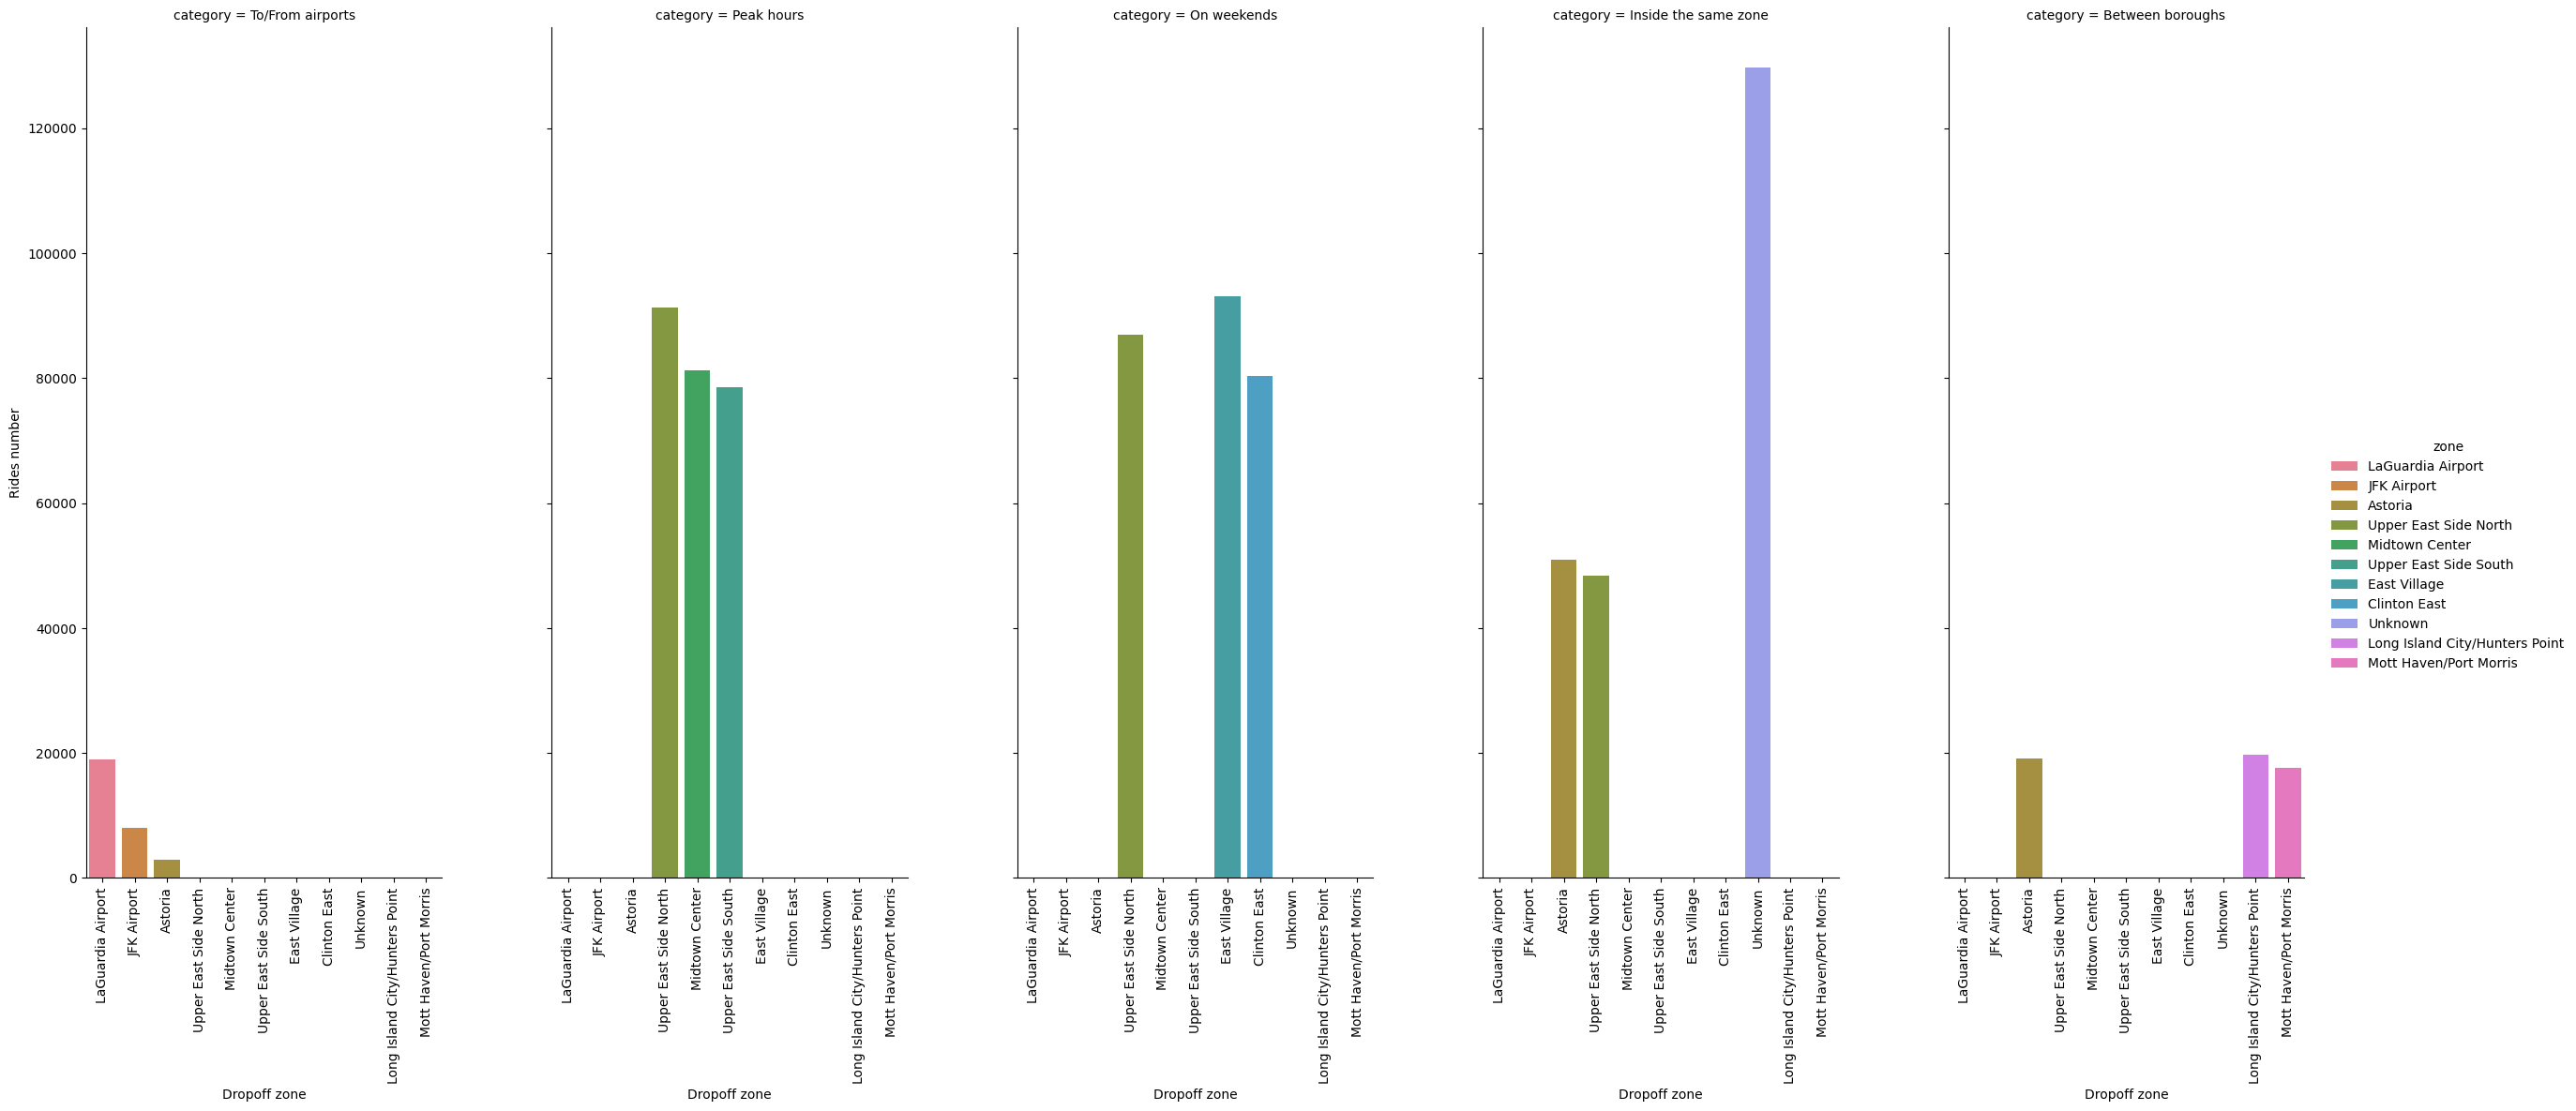

### 6. Способы оплаты для различных типов поездок

Рассматриваем предпочтения в оплате для тех же категорий поездок

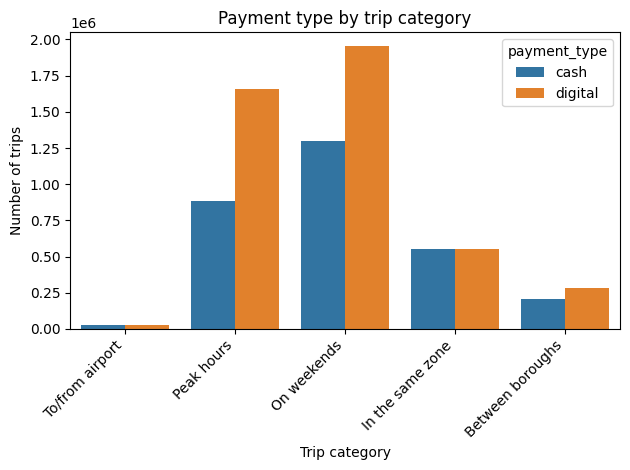

Можно заметить следующую закономерность ...

### 7. Эволюция предпочтений в оплате со временем

Для выявления тренда в способах оплаты агрегируем данные до месяца, более мелкое дробление избыточно.

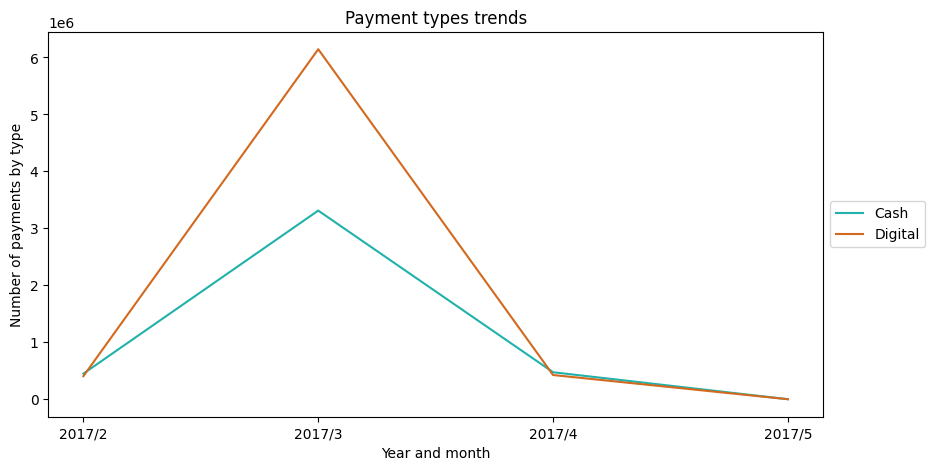

Число оплат наличными ...

### 8. Возможность организации райдшеринга для коротких поездок в близлежащих зонах

Для определения возможности райдшеринга выбираем поездки с числом пассажиров не более 2, на короткие или нормальные расстояния, у которых начальная и конечная зона совпадают. Группируем время отправления по 15-минутным интервалам. Используем materialized view mv_trip_vectors. Отображжаем полученные результаты в виде тепловой карты для 50 наиболее вероятных кандидатов.

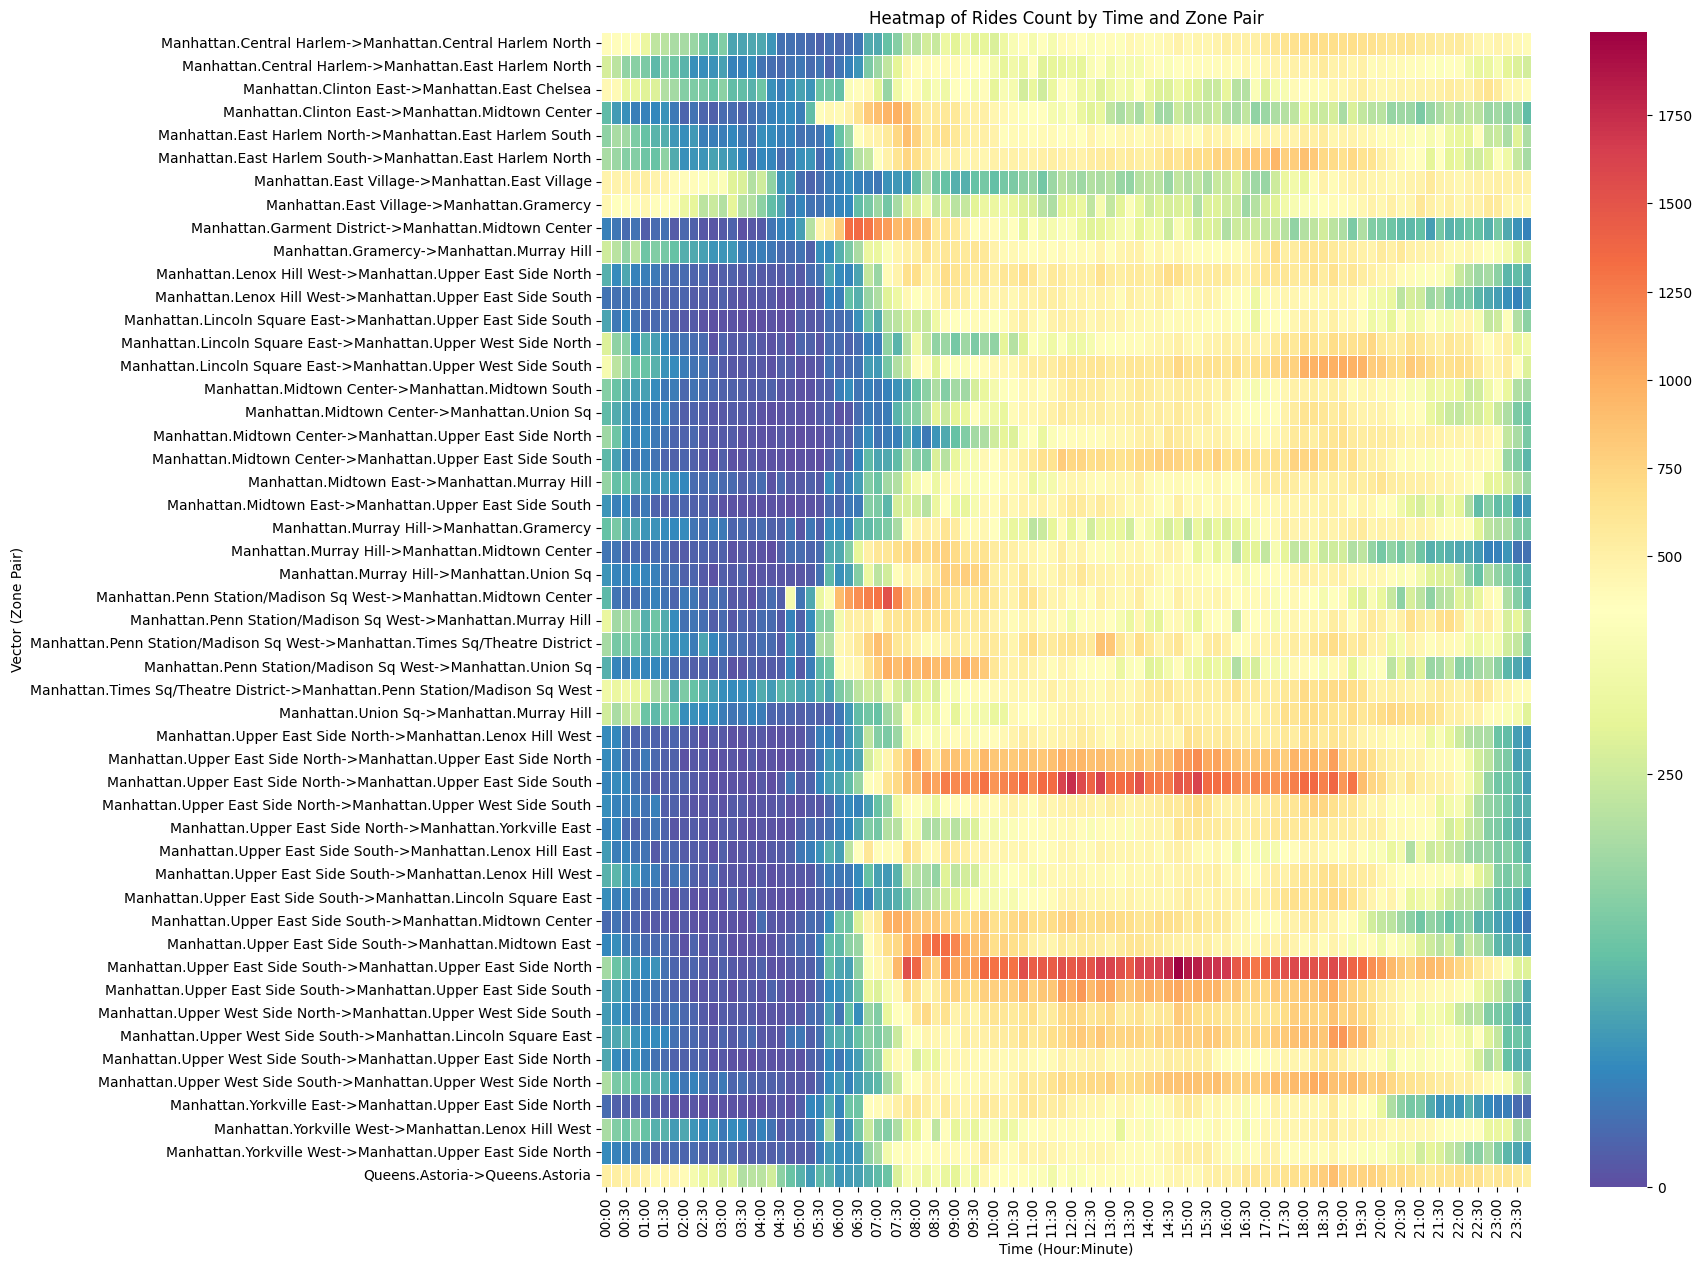

Исходя из тепловой карты выше есть смысл запустить райдшаринг между некоторыми зонами в дневное время.

## Предложения по оптимизации

## Заключение